# Technical project: Linear Time-variant Linear-Quadratic Regulators

This project aims to explore the concept of time-variant linear-quadratic regulators and their applications in various control systems.

## Introduction

A time-variant system is a system whose output response depends on moment of observation as well as moment of input signal application. In other words, a time delay or time advance of input not only shifts the output signal in time but also changes other parameters and behavior. Time variant systems respond differently to the same input at different times. Linear-time variant (LTV) systems are the ones whose parameters vary with time according to previously specified laws. Mathematically, there is a well defined dependence of the system over time and over the input parameters that change over time.

We can obtain such systems by using linearization along the specified trajectory, since the Jacobians that we will use in linearized system are dependent on time step.

In this project we will try to stabilize [this manipulator](https://github.com/lvjonok/yet_another_menagerie/tree/281bab460dc850ee59fee741b8831401b6d91ef5/z1) along predifined trajectory using [Linear-Quadratic Regulator](https://en.wikipedia.org/wiki/Linear–quadratic_regulator)

In [1]:
import numpy as np 
from darli.models import RobotModel
import casadi as cs
from matplotlib import pyplot as plt
from scipy.signal import cont2discrete as discrete
import mediapy as media
import mujoco

Matplotlib created a temporary cache directory at /tmp/matplotlib-mtlbhnbm because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Model loading

In [2]:
model_path = './yet_another_menagerie/z1/z1.urdf'
model = RobotModel(model_path, bodies_names={'end_effector': 'link06'})

From loaded model we need to get number of generalized coordinates $n_q$, number of generalized velocities $n_{dq}$ and number of control parameters $n_u$

In [3]:
n_q, n_dq, n_u = model.nq, model.nv, model.nu

## Defining trajectory

In this section we will define desired motion trajectory.

### Time bounds

In [4]:
t_final = 9 # time for the motion
freq = 100
t = np.linspace(0, t_final, freq)

### Trajectory function

Definition of the function of end-effector position, dependent on time step. The main condition for the trajectory - it should be continuous 

In [5]:
traj = np.stack([
    0.3 * np.cos((2 * np.pi) / t_final * t),
    0.3 * np.sin((2 * np.pi) / t_final * t),
    0.3 + 0.2*np.sin(2 * (2 * np.pi) / t_final * t)
]
)

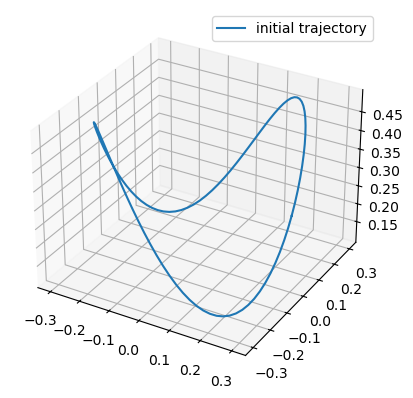

In [6]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(traj[0], traj[1], traj[2], label='initial trajectory')

plt.legend()

plt.show()

## Finding appropriate generalized coordinates for this trajectory 

### Solution

We will use numerical optimization methods to minimize the difference between obtained position of end-effector and the desired one

### Problem definition

In [7]:
# Defining problem, 
opti_problem = cs.Opti()

# Defining variables for optimization
q = opti_problem.variable(n_q, len(t))
dq = opti_problem.variable(n_dq, len(t))

In [8]:
 # Positions of end-effector for each q
positions = model.body('end_effector').position(q)

# Desired positions
desired_positions = opti_problem.parameter(3, len(t)) 

In [9]:
# Defining cost function
cost = cs.sumsqr(positions - desired_positions)
opti_problem.minimize(cost)

### Constraints definition

In [10]:
# Defining constraints

for i in range(len(t)-1):
    # Velocity definition constraint
    opti_problem.subject_to(dq[:, i+1] == (q[:, i+1] - q[:, i])/(t_final / freq))

# Positional constraints of the manipulator
opti_problem.subject_to(opti_problem.bounded(model.q_min, q, model.q_max))
opti_problem.subject_to(dq[:, 0] == np.zeros(n_dq))
opti_problem.solver('ipopt')

# Constraints on desired position
opti_problem.set_value(desired_positions, traj) 

#### Velocity boundings

Initially, I did not include constraints on maximum velocity. However, I decided to bound velocity due to several factors. Firstly, without constraints I get great errors in joints (especially in the places where manipulator cannot follow the trajectory, and manipulator has to change its velocity extremely fast). Secondly, the interpolated motion without these constraints differs from motion obtained in current section and become more chaotic. Therefore, , since it will produce smoother motion.

If you want to check the results without velocity boundings, simply skip code section below.

In [11]:
# Defining velocity boundings
dq_min = -np.pi*np.ones(n_dq)
dq_max = np.pi*np.ones(n_dq)

# Adding constraints
for i in range(len(t)-1):
    # Velocity boundings
    opti_problem.subject_to(opti_problem.bounded(dq_min, dq[:, i+1], dq_max))

### Solving

In [12]:
# Solving
opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1788
Number of nonzeros in inequality constraint Jacobian.:     1194
Number of nonzeros in Lagrangian Hessian.............:     1500

Total number of variables............................:     1200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 2 (nx = 1200)
  #parameters: 1 (np = 300)
  #constraints: 200 (ng = 1794)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

### Results

Let's check how obtained trajectory differs from desired one

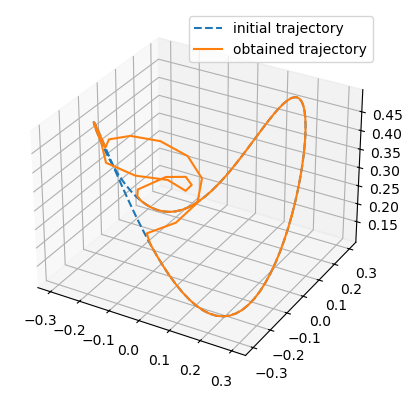

In [13]:
q_values = opti_problem.value(q).T
opt_positions = model.body('end_effector').position(q_values.T).toarray()
ax = plt.figure().add_subplot(projection='3d')

ax.plot(traj[0], traj[1], traj[2], '--', label='initial trajectory') # plotting initial trajectory
ax.plot(opt_positions[0], opt_positions[1], opt_positions[2], label='obtained trajectory') # plotting trajectory obtained from optimization

plt.legend()

plt.show()

## Increasing rate

The rate of the trajectory discretization is chosen to be relaively small in order to simplify optimization process from above. Nevertheless, it may be not enough to get a great controller performance. Therefore, we will interpolate trajectory

### Creating interpolation function for generalized coordinates using [lookup-tables](https://web.casadi.org/docs/#using-lookup-tables)

In [14]:
# Interpolating q
q_inter = [cs.interpolant("LUT", "bspline", [t], q_values[:, i]) for i in range(n_q)]
q_f = lambda t: np.array([q_inter[i](t) for i in range(n_q)]).reshape(n_q, -1)

# Interpolating dq
dq_values = opti_problem.value(dq).T
dq_inter= [cs.interpolant("LUT", "bspline", [t], dq_values[:, i]) for i in range(n_q)]
dq_f = lambda t: np.array([dq_inter[i](t) for i in range(n_q)]).reshape(n_q, -1)

### Interpolating $\ddot q$

There are, at least, 2 different ways to define $\ddot q(t)$:
1) Using numerical differentiation on $\dot q $ values obtained from [optimization above](#finding-appropriate-generalized-coordinates-for-this-trajectory), and then define function using interpolation
2) Using jacobian of $\dot q(t)$ interpolation function from [section above](#creating-interpolation-function-for-generalized-coordinates-using-lookup-tables)

In [15]:
# Method 1
ddq = []
for i in range(len(t)):
    ddq.append((dq_values[(i+1)%len(t)] - dq_values[i])/(t_final / freq))
ddq = np.array(ddq)
ddq_inter = [cs.interpolant("LUT", "bspline", [t], ddq[:, i]) for i in range(n_q)]
ddq_f = lambda t: np.array([ddq_inter[i](t) for i in range(n_q)]).reshape(n_q, -1)

In [16]:
# Method 2
ddq_f1 = lambda t: np.array([dq_inter[i].jacobian()(t, dq_f(t)[i]) for i in range(n_q)]).reshape(n_q, -1)

Further, I will use interpolation function from method 2, since this function should be more appropriate for working in new interpolated domain. However, I will leave the opportunity to switch to the function from $1^{st}$ method to increase solution variability.

### Defining controller frequency

In [17]:
controller_freq = 1000
controller_t = np.linspace(0, t_final, controller_freq)

### Plotting trajectory with updated frequency

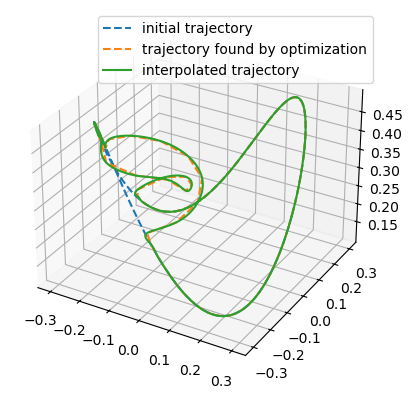

In [18]:
inter_positions = model.body('end_effector').position(q_f(controller_t)).toarray()
ax = plt.figure().add_subplot(projection='3d')

ax.plot(traj[0], traj[1], traj[2], '--', label='initial trajectory')
ax.plot(opt_positions[0], opt_positions[1], opt_positions[2], '--', label='trajectory found by optimization')
ax.plot(inter_positions[0], inter_positions[1], inter_positions[2], label='interpolated trajectory')

plt.legend()

plt.show()

## Control 

### Mathematical base of the solution

According to [this lecture](https://youtu.be/S5LavPCJ5vw?si=OlKwObU5XlpnEziG&t=3115) sytem defines as:

$$x_{t+1}=A_tx_t+B_tu_t $$

Cost defines as:

$$g(x_t, u_t)=x^T_t Q_t x_t + u^T_t R_t u_t$$

Control gains $K_i$ cam be found as:

$$K_i=-(R_{H-i} + B^T_{H-i}P_{i-1}B_{H-i})^{-1}B^T_{H-i}P_{i-1}A_{H-i}$$

$P_i$ can be found as:

$$P_i = Q_{H-i}+K^T_iR_{H-i}K_i+(A_{H-i}+B_{H-i}K_i)^T P_{i-1}(A_{H-i} + B_{H-i}K_i)$$

State $x$ in my case is:
$
\begin{bmatrix} q_1 \\ q_2 \\ ... \\ q_6 \\ \dot q_1 \\ \dot q_2 \\ ... \\ \dot q_6
\end{bmatrix}
$

Since for each state $x_i$ we stabilize system around some point that may not equal to 0, control law will be the following:
$$u=K_ix_i+u^*, \text{ there } u^* \text{is desired control}$$

### Defining $Q_i$ and $R_i$ matrices

For the simplyfication I will use same $Q$ and $R$ for each state

In [19]:
Q = np.eye(n_q+n_dq)
R = np.eye(n_u)*0.005

### Calculating $K_i$

In [20]:
q_des = q_f(controller_t).T
dq_des= dq_f(controller_t).T
ddq_des = ddq_f1(controller_t).T
# Uncomment line below to change interpolation for ddq
# ddq_i = ddq_f(controller_t)
K = []
u_des = []
P_i = Q # P_0
for i in range(len(controller_t)):
    # Get current desired system state
    q_i = q_des[len(controller_t) - 1 - i]
    dq_i = dq_des[len(controller_t) - 1 - i]
    ddq_i = ddq_des[len(controller_t) - 1 - i]
    

    # Solving inverse dynamics problem to obtain u
    u_i = model.inverse_dynamics(q_i, dq_i, ddq_i).toarray().ravel() # calculating u^{*}_{H-i}
    

    u_des.insert(0, u_i) # adding u_{H-i} to the beginning of the list, so values of u_des will be in the right order
    
    # Model linearization, requires to know control in general case
    A_i = model.state_space.state_jacobian([*q_i, *dq_i], u_i) # finding A_{H-i} in continuous domain
    B_i = model.state_space.input_jacobian([*q_i, *dq_i], u_i) # finding B_{H-i} in continuous domain
    
    # Model discretization
    A_i, B_i, _, _, _ = discrete((A_i, B_i, 0, 0), (t_final / controller_freq))
    
    # Recalculating the terms
    K_i = -np.linalg.inv(R + B_i.T @ P_i @ B_i) @ B_i.T @ P_i @ A_i
    P_i = Q + K_i.T @ R @ K_i + (A_i + B_i @ K_i).T @ P_i @ (A_i + B_i @ K_i)
    # Saving K gain
    K.append(K_i)

### Simulation, error calculation

In [21]:
mj_model = mujoco.MjModel.from_xml_path("./yet_another_menagerie/z1/scene.xml")
data = mujoco.MjData(mj_model)
mj_model.opt.timestep = 1e-3

renderer = mujoco.Renderer(mj_model)
scene_option = mujoco.MjvOption()

#### Defining parameters for the simulation

In [22]:
duration = t_final
framerate = 60

#### Simulation with control

In [23]:
# Simulate and display video.
frames = [] # list of frames for video
torques = [] # list of torques applyed (control that we give)
errors = [] # list of errors obtained
time = []
t = t_final / controller_freq # next closest point of controller time
time_idx = 0 # closest index to current moment of simulation

while data.time < duration: # while simulation is not ended
    q_i, dq_i = data.qpos.copy(), data.qvel.copy(),  # get positions and velocities
    x_i = np.concatenate((q_i, dq_i)) # stack them to the current state

    if data.time > t: # if current time is less than next defined controller time point
        t += t_final / controller_freq # change next closest point
        time_idx = (time_idx + 1) % len(controller_t) # update current time index
    time.append(data.time)
    K_i = K[time_idx] # get appropriate K_i for current time
    x_i_des = np.concatenate((q_des[time_idx], dq_des[time_idx])) # get appropriate desired position for current time
    u_i_des = u_des[time_idx] # get appropriate desired control for current time
    
    u =  K_i @ (x_i - x_i_des) + u_i_des # calculate control according to formula above
    data.ctrl = np.array(u).reshape(mj_model.nu, ) # apply control to model

    errors.append(x_i - x_i_des) # calculate and save errors
    torques.append(data.ctrl.copy()) # calculate and save control torque

    mujoco.mj_step(mj_model, data)

    if len(frames) < data.time * framerate: # not frames are rendered
        renderer.update_scene(data, scene_option=scene_option) # update scene
        pixels = renderer.render()
        frames.append(pixels) # add frame
    
media.show_video(frames, fps=framerate) # show video

### Plotting Errors in joints

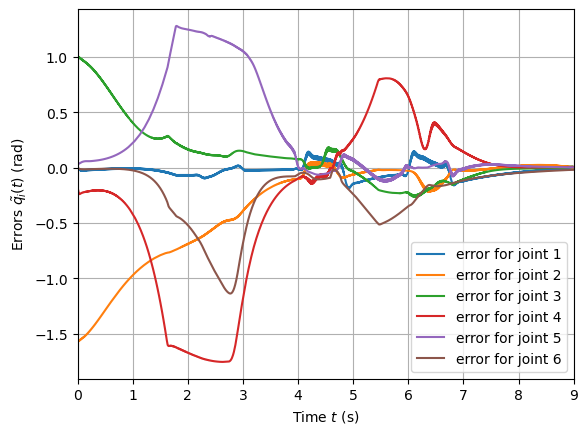

In [24]:
errors = np.array(errors)
for i in range(n_q):
    plt.plot(time, errors[:, i], label=f'error for joint {i + 1}')
plt.grid(True)
plt.ylabel(r'Errors $\tilde{q_{i}}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.xlim(0, duration)
plt.legend()
plt.show()

### Plotting Torques in joints

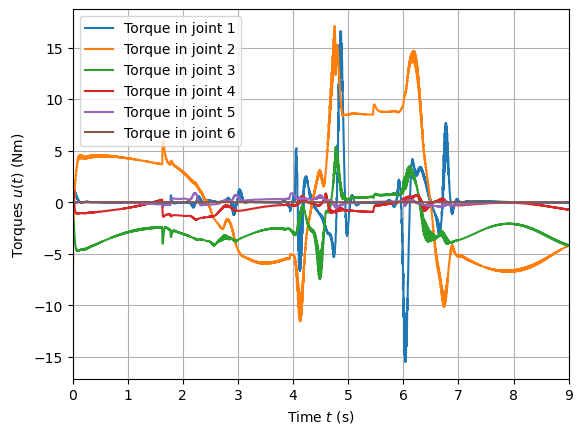

In [25]:
torques = np.array(torques)
for i in range(n_u):
    plt.plot(time, torques[:, i], label=f'Torque in joint {i + 1}')
plt.grid(True)
plt.ylabel(r'Torques $u(t)$ (Nm)')
plt.xlabel(r'Time $t$ (s)')
plt.xlim(0, duration)
plt.legend()
plt.show()